In [100]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, resize
import os
import random
import torchvision.transforms as tf
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pandas as pd

# Helper functions

In [2]:
labels = {
    'background': 0,
    'low_hand': 1,
    'torso' : 2,
    'low_leg' : 3,
    'head' : 4,
    'up_leg' : 5,
    'up_hand' : 6
}
hierarchy = {
    0 : [labels["head"], labels["torso"], labels["up_hand"], labels["low_hand"], labels["up_leg"], labels["low_leg"]],
    1 : [labels["head"], labels["torso"], labels["up_hand"], labels["low_hand"]],
    2 : [labels["up_leg"], labels["low_leg"]],
    3 : [labels["head"]],
    4 : [labels["torso"]],
    5 : [labels["up_hand"]],
    6 : [labels["low_hand"]],
    7 : [labels["up_leg"]],
    8 : [labels["low_leg"]],
}


def get_binary_mask(mask, body_parts : list):
    """
    Generates a map for particular hierarchy level combining body parts
    """
    new_mask = torch.zeros_like(mask)
    for part in body_parts:
      new_mask = torch.where(mask == part,1.0, new_mask)
    return new_mask.squeeze(0)

def get_masks(mask):
  bin_masks = torch.zeros(9,224,224)
  for j in range(9):
    bin_masks[j] = get_binary_mask(mask, hierarchy[j])
  return bin_masks

tree_paths = [
    [0, 1, 6],
    [0, 1, 4],
    [0, 2, 8],
    [0, 1, 3],
    [0, 2, 7],
    [0, 1, 5]
   ]
def combine_masks(preds):
  """
  scores: output from network BxCxWxH
  Finds argmax path in hierarchy tree
  """
  if preds.dim() == 3:
    preds = preds.unsqueeze(0)
  #pred = torch.zeros((scores.size()[0], 224, 224), dtype = torch.uint8)
  path_sums = torch.zeros((preds.size()[0], 6, 224, 224))
  for i, path in enumerate(tree_paths):
    path_sums[:,i] = preds[:,path].sum(1)

  val, indx = torch.max(path_sums, dim = 1) # Bx224x224
  pred = torch.where(val > 0.5, indx + 1, 0).type(dtype = torch.uint8)
  return pred

In [3]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download and preprocess data

In [4]:
!gdown 1unIkraozhmsFtkfneZVhw8JMOQ8jv78J
!unzip Pascal-part.zip;

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Pascal-part/gt_masks/2009_000379.npy  
  inflating: Pascal-part/gt_masks/2009_000397.npy  
  inflating: Pascal-part/gt_masks/2009_000405.npy  
  inflating: Pascal-part/gt_masks/2009_000408.npy  
  inflating: Pascal-part/gt_masks/2009_000411.npy  
  inflating: Pascal-part/gt_masks/2009_000418.npy  
  inflating: Pascal-part/gt_masks/2009_000421.npy  
  inflating: Pascal-part/gt_masks/2009_000430.npy  
  inflating: Pascal-part/gt_masks/2009_000449.npy  
  inflating: Pascal-part/gt_masks/2009_000453.npy  
  inflating: Pascal-part/gt_masks/2009_000455.npy  
  inflating: Pascal-part/gt_masks/2009_000456.npy  
  inflating: Pascal-part/gt_masks/2009_000457.npy  
  inflating: Pascal-part/gt_masks/2009_000461.npy  
  inflating: Pascal-part/gt_masks/2009_000463.npy  
  inflating: Pascal-part/gt_masks/2009_000464.npy  
  inflating: Pascal-part/gt_masks/2009_000474.npy  
  inflating: Pascal-part/gt_masks/2009_000496.np

In [5]:
imgs_val = []
masks_val = []
path_imgs = "/content/Pascal-part/JPEGImages"
path_masks  = "/content/Pascal-part/gt_masks"

# load imgs/masks id's
with open("/content/Pascal-part/val_id.txt", "r") as f:
  val_id = [line.rstrip('\n') for line in f]


for img in os.listdir(path_imgs):
    path_img = os.path.join(path_imgs, img)
    path_mask = os.path.join(path_masks, img.rstrip(".jpg") + ".npy")
    # load valid set
    if img.rstrip(".jpg") in val_id:
      imgs_val.append(Image.open(path_img))
      masks_val.append(torch.from_numpy(np.load(path_mask)))

In [6]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')

class toNumpy:
  def __call__(self, image : torch.Tensor):
    return image.numpy()

class ResNetNormalize:
  def __call__(self, image : np.array):
    return preprocess_input(np.moveaxis(image, 0, 2))

class SquarePad:
  def __call__(self, image):
    if isinstance(image, torch.Tensor):
        h, w = image.size()
    else:
        w, h = image.size

    max_wh = np.max([w, h])
    hp = int((max_wh - w) / 2)
    vp = int((max_wh - h) / 2)
    padding = (hp, vp, hp, vp)
    if isinstance(image, torch.Tensor):
      return F.pad(image, padding, 'constant', 0.).unsqueeze(0)
    else:
      return F.pad(pil_to_tensor(image), padding, 'constant', 0.)

# now use it as the replacement of transforms.Pad class
image_size = 224
transform_img=tf.Compose([
    SquarePad(),
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    toNumpy(),
    ResNetNormalize(),
    tf.ToTensor()
])

transform_mask =tf.Compose([
    SquarePad(),
    tf.Resize(image_size, interpolation=tf.InterpolationMode.NEAREST), # no interpolation fpr masks to keep the correct class labels
    tf.CenterCrop(image_size),
])


In [7]:
img_sz = 224
valset_img = torch.zeros(len(imgs_val), 3, img_sz, img_sz)
valset_msk = torch.zeros(len(masks_val), img_sz, img_sz)
for i in range(len(imgs_val)):
  valset_img[i] = transform_img(imgs_val[i])
  valset_msk[i] =  transform_mask(masks_val[i])

# Download pre-trained models

In [8]:
!gdown 1JHhWwzJZKSQq2lWh3SzfWiV3Us9Y5viZ

Downloading...
From (original): https://drive.google.com/uc?id=1JHhWwzJZKSQq2lWh3SzfWiV3Us9Y5viZ
From (redirected): https://drive.google.com/uc?id=1JHhWwzJZKSQq2lWh3SzfWiV3Us9Y5viZ&confirm=t&uuid=92e57051-edba-46e4-b0c9-0350a93f3f77
To: /content/unet_bce_loss.pt
100% 279M/279M [00:01<00:00, 175MB/s]


In [84]:
!gdown 1gLg4zV2AO5WDHoa1S84jnLwavui_VqGZ

Downloading...
From (original): https://drive.google.com/uc?id=1gLg4zV2AO5WDHoa1S84jnLwavui_VqGZ
From (redirected): https://drive.google.com/uc?id=1gLg4zV2AO5WDHoa1S84jnLwavui_VqGZ&confirm=t&uuid=dbbfc9a6-a0b9-4830-8fca-8b6a6b9004d2
To: /content/unet_focal_tree_loss.pt
100% 279M/279M [00:06<00:00, 40.8MB/s]


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
model_data1 = torch.load("/content/unet_bce_loss.pt", map_location = device)
model_data1.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler', 'losses'])

In [85]:
model_data2 = torch.load("/content/unet_focal_tree_loss.pt", map_location = device)


In [65]:
import segmentation_models_pytorch as smp

model1 = smp.Unet(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=9                    # model output channels (number of classes in your dataset)
)
model1.segmentation_head[2].activation = torch.nn.Sigmoid()

In [81]:
import segmentation_models_pytorch as smp

model2 = smp.Unet(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=9                    # model output channels (number of classes in your dataset)
)
model2.segmentation_head[2].activation = torch.nn.Sigmoid()

In [86]:
model1.load_state_dict(model_data1['model_state_dict']) # bce_loss
model2.load_state_dict(model_data2['model_state_dict']) #focal_tree_loss

<All keys matched successfully>

# Inference

In [13]:
tree_paths = [
    [0, 1, 6],
    [0, 1, 4],
    [0, 2, 8],
    [0, 1, 3],
    [0, 2, 7],
    [0, 1, 5]
   ]
def inference(scores):
  """
  scores: output from network BxCxWxH
  Finds argmax path in hierarchy tree and returns 9-binary masks for each level
  """
  #pred = torch.zeros((scores.size()[0], 224, 224), dtype = torch.uint8)
  path_sums = torch.zeros((scores.size()[0], 6, 224, 224))
  for i, path in enumerate(tree_paths):
    path_sums[:,i] = scores[:,path].mean(1)

  indx = torch.argmax(path_sums, dim = 1) # Bx224x224
  pred = torch.zeros_like(scores)
  for i in range(6):
      # pred[:, tree_path].shape = Bx3xWxH, indx.shape = BxWxH -> resize for broadcasting along singlton dimension Bx1xWxH
      pred[:,tree_paths[i]] = torch.where(indx.view(-1, 1, 224,224)  == i, scores[:,tree_paths[i]], pred[:,tree_paths[i]])
  return pred

# Distribution of IoU metrics on validation set

---



In [75]:
def IoU(outputs: torch.Tensor, labels: torch.Tensor):
    """
    Implementation of IoU, labels can be floats.
    Metric Reduction: mean over batch
    Threshold is 0.5 and implemented with torch.round()
    Returns: IoU for each channel summed over batch
    """
    outputs = torch.round(outputs).byte()  # BATCH x C x H x W
    labels = torch.round(labels).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((2, 3))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((2, 3))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean(0)  # sum over BATCH

hier_levels = {
    'body': [0],
    'up_low_body': [1,2],
    'body_parts' : [3,4,5,6,7,8]
}


def get_mean_IoU(infer_masks, tar_masks):
  """
  Returns mmean IoU score for each level of hierarchy summed over batches
  """
  # calculate mean IoU for each level of hierarchy
  ious = IoU(infer_masks, tar_masks)
  lev1 = ious[hier_levels["body"]].item()
  lev2 = ious[hier_levels["up_low_body"]].mean().item()
  lev3 = ious[hier_levels["body_parts"]].mean().item()
  return lev1, lev2, lev3

In [79]:
def evaluate_model(model):
  model.to(device)
  model.eval()
  iou1 =np.zeros(len(valset_img))
  iou2 =np.zeros(len(valset_img))
  iou3 =np.zeros(len(valset_img))
  for i,img in tqdm(enumerate(valset_img)):
    with torch.no_grad():
      score = model(img.unsqueeze(0).to(device))
      iou1[i], iou2[i], iou3[i] = get_mean_IoU(inference(score.cpu()), get_masks(valset_msk[i]).unsqueeze(0))
  return iou1, iou2, iou3

In [77]:
log1 = evaluate_model(model1)


0it [00:00, ?it/s]

In [87]:
log2 = evaluate_model(model2)

0it [00:00, ?it/s]

Histograms of mean IoU for each level of hierarchy

Text(0.5, 1.0, 'IouU metrics for each level of hierarchy for model with BCE loss')

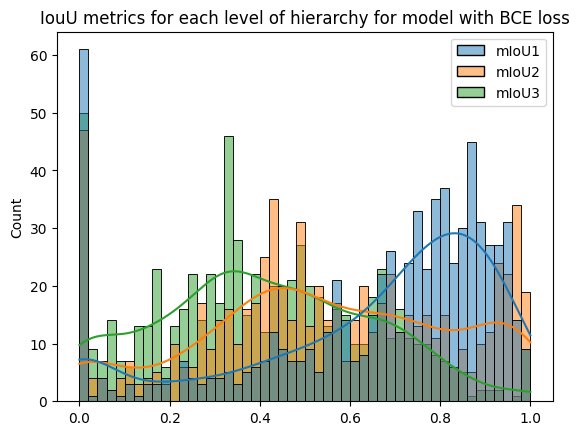

In [90]:
import seaborn as sns
sns.histplot({"mIoU1" : log1[0], "mIoU2" : log1[1], "mIoU3" : log1[2]}, kde = True, bins = 50)
plt.title("IouU metrics for each level of hierarchy for model with BCE loss")

In [104]:
meanIoU = pd.DataFrame({"mIoU1":[log1[0].mean(), log2[0].mean()],"mIoU2":[log1[1].mean(), log2[1].mean()],"mIoU3":[log1[2].mean(), log2[2].mean()]}, index = ["BCE Loss", "Focal Tree-Min Loss"])
meanIoU

,mIoU1,mIoU2,mIoU3
BCE Loss,0.650833,0.545814,0.407293
Focal Tree-Min Loss,0.659002,0.549789,0.416288


Text(0.5, 1.0, 'IouU metrics for each level of hierarchy for model with Focal Tree loss')

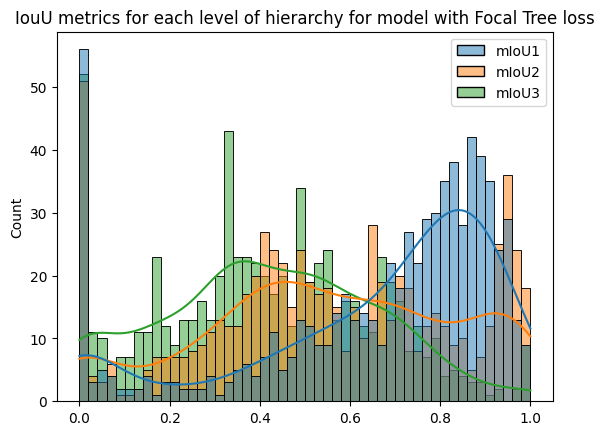

In [91]:
sns.histplot({"mIoU1" : log2[0], "mIoU2" : log2[1], "mIoU3" : log2[2]},  kde = True, bins = 50)
plt.title("IouU metrics for each level of hierarchy for model with Focal Tree loss")

# Predicted masks visualization

In [105]:
tree_paths = [
    [0, 1, 6],
    [0, 1, 4],
    [0, 2, 8],
    [0, 1, 3],
    [0, 2, 7],
    [0, 1, 5]
   ]
def combine_masks(preds):
  """
  scores: output from network BxCxWxH
  Finds argmax path in hierarchy tree
  """
  if preds.dim() == 3:
    preds = preds.unsqueeze(0)
  #pred = torch.zeros((scores.size()[0], 224, 224), dtype = torch.uint8)
  path_sums = torch.zeros((preds.size()[0], 6, 224, 224))
  for i, path in enumerate(tree_paths):
    path_sums[:,i] = preds[:,path].sum(1)

  val, indx = torch.max(path_sums, dim = 1) # Bx224x224
  pred = torch.where(val > 0.5, indx + 1, 0).type(dtype = torch.uint8)
  return pred

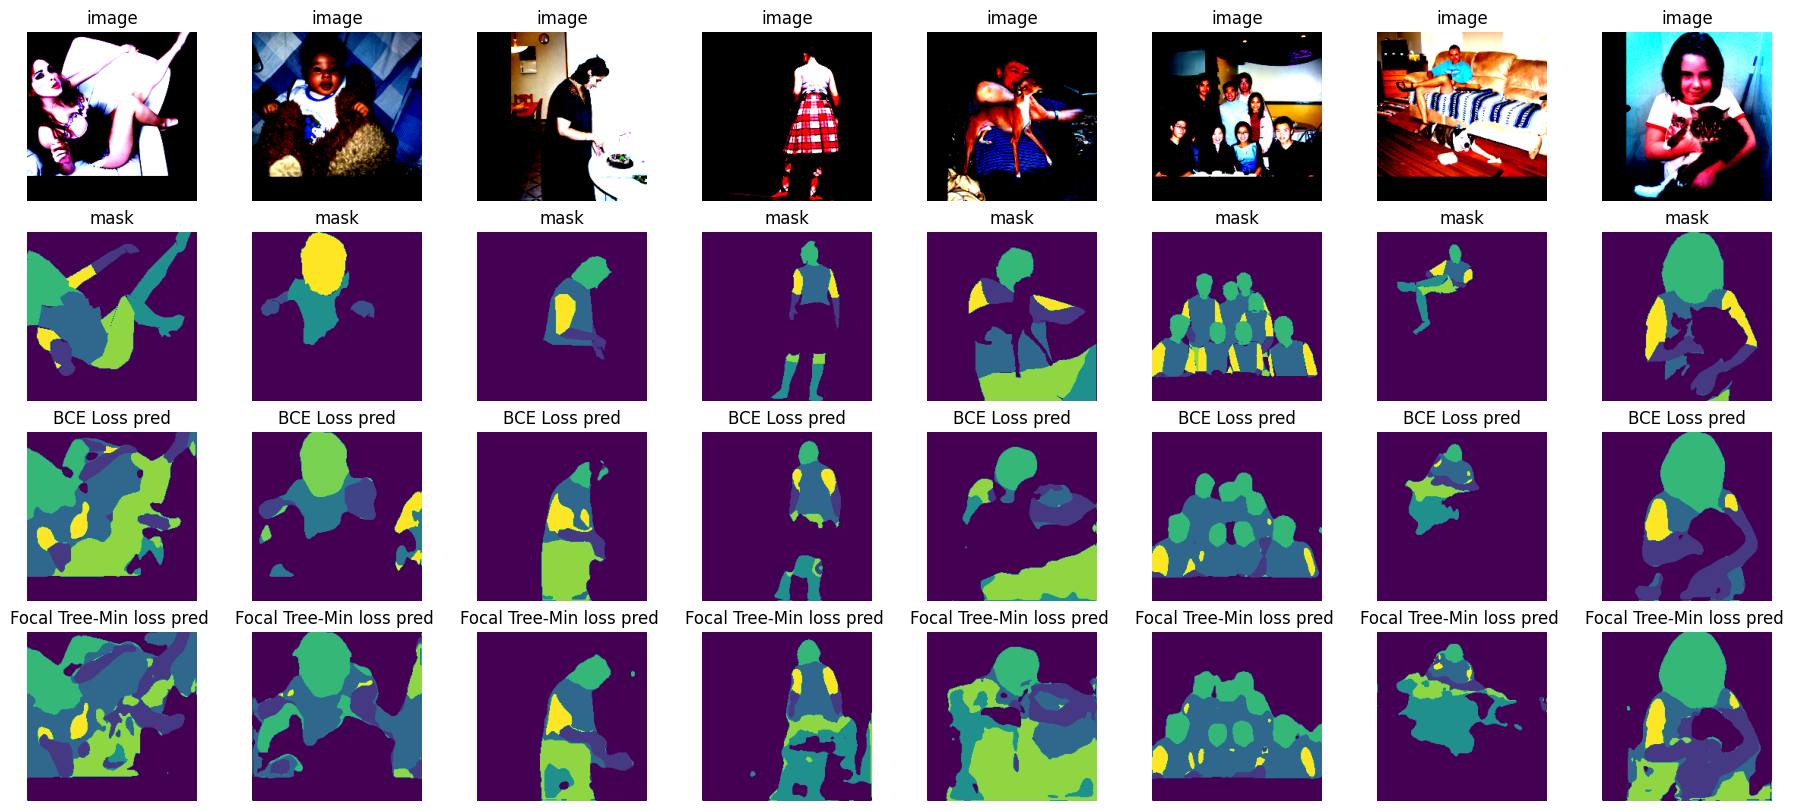

In [116]:
plt.figure(figsize=(18, 8), constrained_layout = True)
nmax = 8
for i in range(nmax):
    j = np.random.randint(0, len(imgs_val) - 1)

    plt.subplot(4, nmax, i+1)
    plt.axis("off")
    plt.title("image")
    plt.imshow(valset_img[j].permute(1,2,0))

    plt.subplot(4, nmax, i+nmax+1)
    plt.axis("off")
    plt.title("mask")
    plt.imshow(valset_msk[j])

    plt.subplot(4, nmax, i+2*nmax+1)
    plt.axis("off")
    plt.title("BCE Loss pred")
    with torch.no_grad():
      model1.eval()
      pred1 = inference(model1(valset_img[j].unsqueeze(0).to(device)).cpu()).squeeze()
    plt.imshow(combine_masks(pred1).squeeze())

    plt.subplot(4, nmax, i+3*nmax+1)
    plt.axis("off")
    plt.title("Focal Tree-Min loss pred ")
    with torch.no_grad():
      model2.eval()
      pred2 = inference(model2(valset_img[j].unsqueeze(0).to(device)).cpu()).squeeze()
    plt.imshow(combine_masks(pred2).squeeze())
